In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.layers import Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


# Explore Data

## Read Data from given train and test csvs

In [3]:
# Read train and test data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [4]:
print('training data size::', train_data.shape)
print('test data size::', test_data.shape)

training data size:: (1225029, 3)
test data size:: (117703, 2)


In [7]:
# Get glimpse of training data
train_data.head()

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [8]:
# Get glimpse of testing data
test_data.head()

,id,url
0,cb9998b8cdaf6235,https://lh3.googleusercontent.com/-q8B91vDIQZY...
1,30728cf6e50a6bc6,https://lh3.googleusercontent.com/-91gJSKTgv5Q...
2,16afbc86b710337d,https://lh3.googleusercontent.com/-GHZdXuf2wMg...
3,d29b2166cf522450,https://lh3.googleusercontent.com/-cWDnYNQhyws...
4,dd5c03b20c21cfba,https://lh3.googleusercontent.com/-PSLN6BloM-k...


## Analyze data

In [19]:
# Unique landmark ids
train_data.nunique()

id             1225029
url            1215770
landmark_id      14952
dtype: int64

### There are 14952 unique landmark ids in the training data

In [9]:
# To find landmark ids counts
train_data['landmark_id'].value_counts()

9633     50010
6051     49806
6599     23218
9779     18309
2061     13183
5554     11033
6651      9444
None      9260
5376      9161
6696      9161
2743      8950
4352      8928
13526     8617
1553      7754
10900     6961
8063      6612
8429      6398
4987      5319
12220     5282
11784     5221
2949      4879
12718     3772
3804      3669
10184     3592
7092      3517
10045     3426
2338      3400
12172     3348
3924      3347
428       3153
         ...  
9562         1
5043         1
11895        1
494          1
3176         1
6261         1
4058         1
6173         1
8835         1
10711        1
5617         1
664          1
708          1
5697         1
4823         1
4329         1
1913         1
12452        1
10995        1
3239         1
7482         1
6423         1
8232         1
10420        1
1527         1
12502        1
3133         1
12703        1
3597         1
13342        1
Name: landmark_id, Length: 14952, dtype: int64

### Given the above counts, the most frequent landmark id is 9633. Also there are landmarks having only 1 image available.

In [11]:
# Let's describe the value counts
train_data['landmark_id'].value_counts().describe()

count    14952.000000
mean        81.930778
std        706.247854
min          1.000000
25%          6.000000
50%         13.500000
75%         45.000000
max      50010.000000
Name: landmark_id, dtype: float64

### Given the describe above, it seems out of 14952 categories, 75% of them having less than 45 examples

In [12]:
# to find missing data for landmark_id (if any)
train_data['landmark_id'].isnull().sum()

0

### There is no missing data in landmark_id column

In [25]:
# to find landmarks with only 1 occurence
df = pd.DataFrame(train_data.landmark_id.value_counts())
df.reset_index(inplace=True)
df.columns = ['landmark_id','occurences']
least_occur_data = df.loc[df['occurences']==1]
least_occur_data

,landmark_id,occurences
14785,2952,1
14786,8381,1
14787,3538,1
14788,7482,1
14789,10007,1
14790,3176,1
14791,7815,1
14792,1984,1
14793,5581,1
14794,9265,1


In [15]:
# to find landmarks having 20 occurences
df.loc[df['occurences']==20]

,landmark_id,occurences
6132,14265,20
6133,12433,20
6134,1614,20
6135,10689,20
6136,11505,20
6137,13348,20
6138,4422,20
6139,7035,20
6140,3041,20
6141,10876,20


In [16]:
# to find landmarks having occurences btw 500 and 550
df.loc[(df['occurences']>=500) & (df['occurences']<550)]

,landmark_id,occurences
327,8885,549
328,13171,548
329,7091,548
330,3888,546
331,3731,545
332,3278,545
333,3397,545
334,10822,544
335,7356,543
336,12609,543


## Visualize Data

In [17]:
# Most frequent landmarks
most_frequent = pd.DataFrame(train_data.landmark_id.value_counts().head(10))
most_frequent.reset_index(inplace=True)
most_frequent.columns = ['landmark_id','occurences']
most_frequent

,landmark_id,occurences
0,9633,50010
1,6051,49806
2,6599,23218
3,9779,18309
4,2061,13183
5,5554,11033
6,6651,9444
7,None,9260
8,5376,9161
9,6696,9161


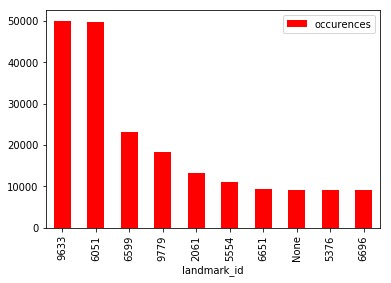

In [18]:
# Lets plot most frequest landmarks
most_frequent.plot('landmark_id','occurences',kind='bar', colormap='autumn')

### Most frequent landmark is 9633 and it appears 50010 times

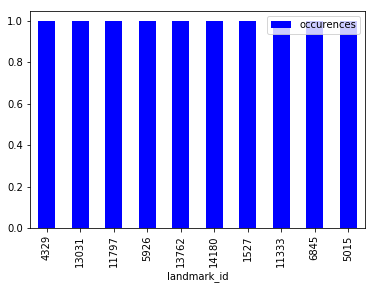

In [32]:
# To plot last 10 least occurred landmarks
least_occur_data.tail(10).plot('landmark_id','occurences',kind='bar', colormap='winter')

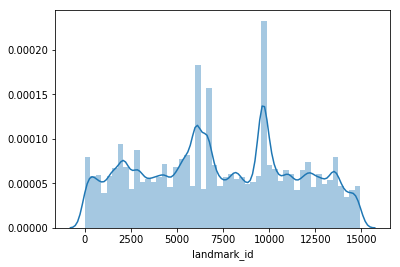

In [20]:
# Landmark Ids distribution and density plot
train_data['landmark_id'][train_data['landmark_id']=='None'] = 0
train_data['landmark_id'] = train_data['landmark_id'].astype(int)
sns.distplot(train_data['landmark_id'])

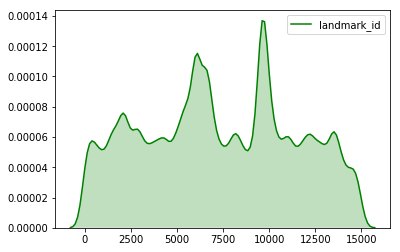

In [24]:
# Landmark Ids density plot
sns.kdeplot(train_data['landmark_id'], color='green', shade=True)

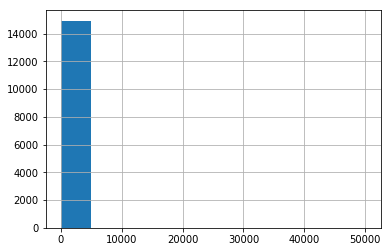

In [21]:
# To explore hist for landmark ids value counts
train_data['landmark_id'].value_counts().hist()

### Display Images

In [34]:
from skimage import io
def display_images_for_category(urls):
    for _,u in urls.head(10).iteritems():
        image = io.imread(u)
        plt.imshow(image)
        plt.show()

In [37]:
# See images of mostly frequest landmark id
category = train_data['landmark_id'].value_counts().keys()[0]
image_urls = train_data[train_data['landmark_id'] == category]['url']

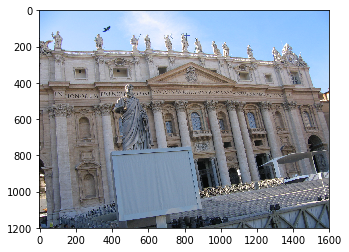

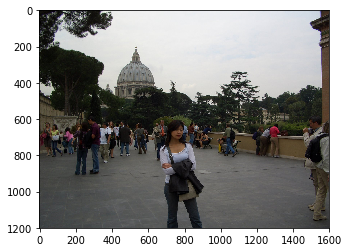

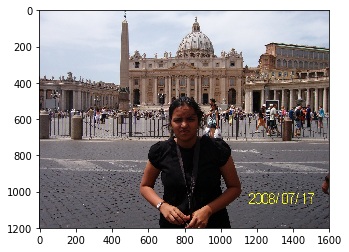

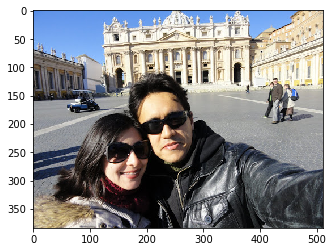

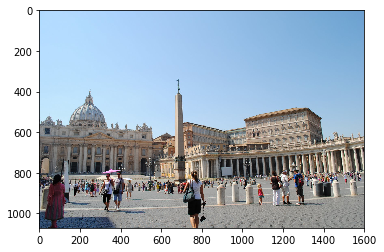

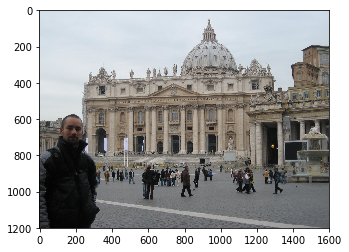

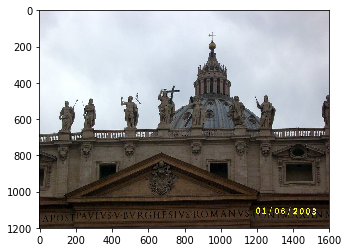

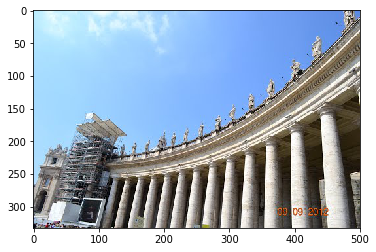

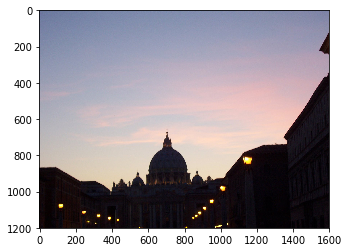

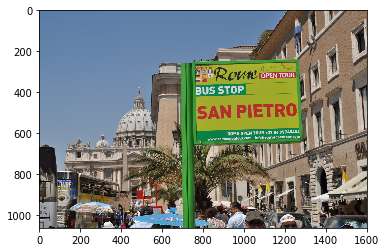

In [38]:
display_images_for_category(image_urls)

In [39]:
from IPython.display import Image
from IPython.core.display import HTML 

def display_category(urls):
    img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
    images_list = ''.join([f"<img style='{img_style}' src='{u}' />" for _, u in urls.head(10).iteritems()])

    display(HTML(images_list))

In [40]:
display_category(image_urls)

In [42]:
## 14366
image_urls_14366 = train_data[train_data['landmark_id'] == 14366]['url']
display_category(image_urls_14366)

In [43]:
## 11095
image_urls_11095 = train_data[train_data['landmark_id'] == 11095]['url']
display_category(image_urls_11095)

In [44]:
# One of least occured image
## 13031
image_urls_13031 = train_data[train_data['landmark_id'] == 13031]['url']
display_category(image_urls_13031)

## Benchmark Model

### KNN (K nearest neighbors)

In [46]:
# Extracts the color histogram from given image
def ext_col_hist(image,bins = (8,8,8)):
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,256,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()

In [47]:
train_dir = './data/train/'
train_names_list = os.listdir(train_dir)

In [49]:
# Get the training data paths
img_path_list = []
for name in train_names_list:
    images = [train_dir+item for item in os.listdir(train_dir+'/')]
    img_path_list.extend(images)

# Get the labels
labels = []
for path in img_path_list:
    l = path.split('_')
    labels.extend(l[2:])
    
labels = [x.replace('.jpg','') for x in labels]

In [50]:
## Encode labels
labels = LabelEncoder().fit_transform(labels)

In [51]:
# Get the color histograms from the images
features = []
for i,img_path in enumerate(img_path_list):
    image = cv2.imread(img_path)
    hist = ext_col_hist(image)
    features.append(hist)
    if(i%1000==0):
        print(str(i)+ "  completed")
print('done.')

0  completed
1000  completed
2000  completed
3000  completed
4000  completed
5000  completed
6000  completed
7000  completed
8000  completed
9000  completed
done.


In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

In [53]:
# KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
## Train model
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')

In [54]:
accuracy = model.score(X_test, y_test)

In [55]:
accuracy

1.0

In [56]:
preds_validation = model.predict_proba(X_test)

In [57]:
preds_validation

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
log_loss(y_test, preds_validation)

1.0306485638555893e-14

## Convolutional Neural Network

In [3]:
from tensorflow.python.client import device_lib

In [4]:
# list down local devices
## To check GPU's listed
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4169143838672143022, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15594933453
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14215410130762944032
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"]

In [3]:
epochs = 50
batch_size = 16

In [4]:
from keras.utils import multi_gpu_model

IMAGE_SIZE = (256, 256)
INPUT_SHAPE = (*IMAGE_SIZE, 3)

def get_pretrained_model(pretrained_model, all_categories):
    if pretrained_model == 'vgg16':
        pretrained_model = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif pretrained_model == 'xception':
        pretrained_model = Xception(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    else:
        pretrained_model = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
        
    # Since the include_top is set to False, pretrained_model.output.shape.ndims is 4, Flatten it
    output = Flatten()(pretrained_model.output)
    # Dropout layer
    output = Dropout(0.5)(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.5)(output)
    ## Since working on almost 100 images of 5 categories for now
    output = Dense(all_categories, activation='softmax')(output)
    
    # create model
    model = Model(pretrained_model.input, output)
    
    # Disable pretrained model layers training
    for layer in pretrained_model.layers:
        layer.trainable = False
    
    model.summary()
    
    # Keras multi gpu suport 
    # parallel_model = multi_gpu_model(model, gpus=8)
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    # parallel_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    # return parallel_model

In [5]:
vgg16_model = get_pretrained_model('vgg16', 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [6]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
)

In [7]:
train_generator = datagen.flow_from_directory(
    directory="./images/train/",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 18611 images belonging to 50 classes.


In [8]:
validation_generator = datagen.flow_from_directory(
    directory="./images/validation/",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 5000 images belonging to 50 classes.


In [10]:
#int(18635/batch_size) =1164
#int(5000/batch_size) = 312
vgg16_model.fit_generator(train_generator,
                            steps_per_epoch=1164, 
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=312 
                         )

Epoch 1/10
1164/1164 [==============================] - 817s 702ms/step - loss: 15.1456 - acc: 0.0545 - val_loss: 14.0605 - val_acc: 0.1190
Epoch 2/10
1164/1164 [==============================] - 769s 661ms/step - loss: 13.9258 - acc: 0.1303 - val_loss: 12.6299 - val_acc: 0.2097
Epoch 4/10
1164/1164 [==============================] - 768s 660ms/step - loss: 13.2484 - acc: 0.1708 - val_loss: 12.1596 - val_acc: 0.2392
Epoch 5/10
1164/1164 [==============================] - 767s 659ms/step - loss: 12.7063 - acc: 0.2049 - val_loss: 11.7989 - val_acc: 0.2620
Epoch 6/10
1164/1164 [==============================] - 767s 659ms/step - loss: 12.3974 - acc: 0.2232 - val_loss: 11.5420 - val_acc: 0.2799
Epoch 7/10
1164/1164 [==============================] - 768s 660ms/step - loss: 12.0983 - acc: 0.2434 - val_loss: 11.0212 - val_acc: 0.3118
Epoch 8/10
1164/1164 [==============================] - 768s 660ms/step - loss: 11.8578 - acc: 0.2586 - val_loss: 10.4552 - val_acc: 0.3457
Epoch 9/10
1164/1164

In [11]:
vgg16_model.save_weights('vgg16_model_10.h5')

In [12]:
vgg16_model.history.history

{'val_loss': [14.06045809158912,
  13.730360213290439,
  12.629943432815576,
  12.159574190265294,
  11.79889175635471,
  11.541968106840816,
  11.02118619487144,
  10.455204374334786,
  10.41526126402339,
  10.06809815243006],
 'val_acc': [0.11899038461538461,
  0.14345906902086678,
  0.2096709470304976,
  0.2391653290529695,
  0.26203852327447835,
  0.2798956661316212,
  0.31179775280898875,
  0.34570626003210275,
  0.3477126805778491,
  0.37018459069020865],
 'loss': [15.145659137770902,
  14.670597144638045,
  13.92532876790146,
  13.248099770428158,
  12.706385579708439,
  12.397730486836009,
  12.098331717953133,
  11.857454981942182,
  11.596547632391548,
  11.372100941732798],
 'acc': [0.05451127819708928,
  0.08566058002468338,
  0.130343716433942,
  0.17083780880933416,
  0.20488721804511278,
  0.22314715360468362,
  0.24344790547798068,
  0.25859291085175107,
  0.2726638023566483,
  0.28754027926320036]}

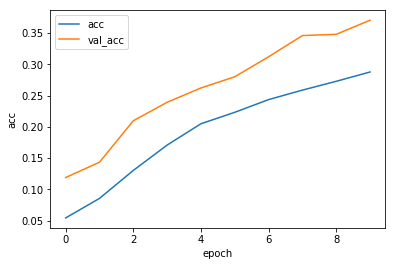

In [14]:
plt.plot(vgg16_model.history.history['acc'], label='acc')
plt.plot(vgg16_model.history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

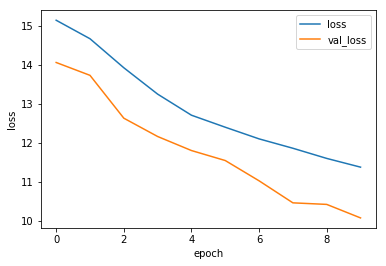

In [15]:
plt.plot(vgg16_model.history.history['loss'], label='loss')
plt.plot(vgg16_model.history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [9]:
# VGG16 epoch 20
vgg16_model.fit_generator(train_generator,
                            steps_per_epoch=100, 
                            epochs=20,
                            validation_data=validation_generator,
                            validation_steps=312 
                         )

Epoch 1/20
100/100 [==============================] - 249s 2s/step - loss: 15.6276 - acc: 0.0231 - val_loss: 15.4796 - val_acc: 0.0371
Epoch 2/20
100/100 [==============================] - 210s 2s/step - loss: 15.3618 - acc: 0.0431 - val_loss: 15.1190 - val_acc: 0.0550
Epoch 3/20
100/100 [==============================] - 209s 2s/step - loss: 15.2506 - acc: 0.0488 - val_loss: 14.9542 - val_acc: 0.0670
Epoch 4/20
100/100 [==============================] - 211s 2s/step - loss: 15.1845 - acc: 0.0537 - val_loss: 14.8938 - val_acc: 0.0700
Epoch 5/20
100/100 [==============================] - 209s 2s/step - loss: 15.2502 - acc: 0.0500 - val_loss: 15.0865 - val_acc: 0.0604
Epoch 6/20
100/100 [==============================] - 211s 2s/step - loss: 15.0702 - acc: 0.0631 - val_loss: 15.0132 - val_acc: 0.0646
Epoch 7/20
100/100 [==============================] - 209s 2s/step - loss: 15.2494 - acc: 0.0512 - val_loss: 14.8562 - val_acc: 0.0730
Epoch 8/20
100/100 [==============================] - 2

In [10]:
vgg16_model.save_weights('vgg16_model_20.h5')

In [9]:
vgg16_model.load_weights('vgg16_model_20.h5')

In [11]:
vgg16_model.history.history

{'val_loss': [15.479555157514719,
  15.119008638311541,
  14.954249247310631,
  14.893762787502038,
  15.086467182655396,
  15.013185496506301,
  14.856239309662993,
  14.700595984298191,
  14.329102491681878,
  14.379968407448757,
  14.58854511805943,
  14.277502877371651,
  14.11469158429778,
  14.17529040775942,
  14.216102489881683,
  13.976083678954295,
  13.836123644061876,
  13.65395253734068,
  13.755647172514546,
  13.465504259014589],
 'val_acc': [0.03705929487179487,
  0.054975922953451044,
  0.06701444622792938,
  0.07002407704654896,
  0.060393258426966294,
  0.06460674157303371,
  0.07303370786516854,
  0.08166131621187801,
  0.10513643659711075,
  0.0997191011235955,
  0.09069020866773676,
  0.110553772070626,
  0.12058587479935795,
  0.1141653290529695,
  0.11215890850722311,
  0.12560192616372393,
  0.13523274478330657,
  0.14606741573033707,
  0.13924558587479935,
  0.15710272873194223],
 'loss': [15.627612380981445,
  15.36175482749939,
  15.250576610565185,
  15.184

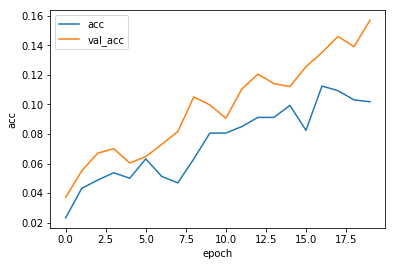

In [12]:
plt.plot(vgg16_model.history.history['acc'], label='acc')
plt.plot(vgg16_model.history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

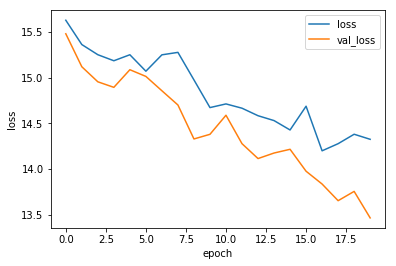

In [13]:
plt.plot(vgg16_model.history.history['loss'], label='loss')
plt.plot(vgg16_model.history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

## Xception

In [7]:
xception_model = get_pretrained_model('xception', 50)

83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
____________________________________________

In [14]:
#int(18635/batch_size) =1164
#int(5000/batch_size) = 312
xception_model.fit_generator(train_generator,
                            steps_per_epoch=1164, 
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=312)

Epoch 1/10
1164/1164 [==============================] - 772s 663ms/step - loss: 3.8896 - acc: 0.0277 - val_loss: 4.2091 - val_acc: 0.0159
Epoch 3/10
1164/1164 [==============================] - 772s 663ms/step - loss: 3.8871 - acc: 0.0265 - val_loss: 7.2969 - val_acc: 0.0205
Epoch 4/10
1164/1164 [==============================] - 771s 662ms/step - loss: 3.8860 - acc: 0.0259 - val_loss: 3.9639 - val_acc: 0.0205
Epoch 5/10
1164/1164 [==============================] - 770s 662ms/step - loss: 3.8914 - acc: 0.0264 - val_loss: 4.2424 - val_acc: 0.0205
Epoch 6/10
1164/1164 [==============================] - 772s 663ms/step - loss: 3.8895 - acc: 0.0272 - val_loss: 4.3835 - val_acc: 0.0205
Epoch 7/10
1164/1164 [==============================] - 770s 661ms/step - loss: 3.8934 - acc: 0.0272 - val_loss: 5.4773 - val_acc: 0.0209
Epoch 8/10
1164/1164 [==============================] - 770s 662ms/step - loss: 3.8852 - acc: 0.0284 - val_loss: 6.6188 - val_acc: 0.0207
Epoch 9/10
1164/1164 [============

In [15]:
xception_model.save_weights('xception_model_10.h5')

In [18]:
xception_model.history.history

{'val_loss': [5.8680788691227255,
  4.20911993146134,
  7.296887642690496,
  3.9639180345673046,
  4.242419858231399,
  4.383540094568488,
  5.477252884814291,
  6.618781031995868,
  4.03895071230195,
  4.575959922031262],
 'val_acc': [0.023237179487179488,
  0.01585072231139647,
  0.020465489566613163,
  0.020465489566613163,
  0.020465489566613163,
  0.020465489566613163,
  0.02086677367576244,
  0.0206661316211878,
  0.019863563402889247,
  0.020064205457463884],
 'loss': [4.31507313576728,
  3.8895480468885215,
  3.887057368045975,
  3.8860205571966446,
  3.8914354720253947,
  3.889232130798438,
  3.8933643605860166,
  3.8851858001262367,
  3.8865217208862304,
  3.890026012168663],
 'acc': [0.0218045112813966,
  0.02765843179377014,
  0.026476906553695077,
  0.02593984962406015,
  0.026369495166487646,
  0.027228786252943196,
  0.027175080558539205,
  0.02835660580021482,
  0.0280343716433942,
  0.028302900107411384]}

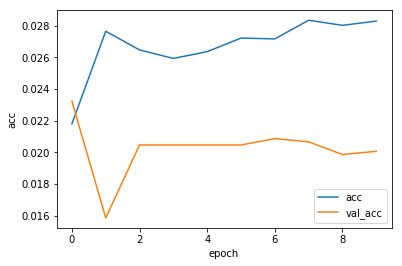

In [16]:
plt.plot(xception_model.history.history['acc'], label='acc')
plt.plot(xception_model.history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

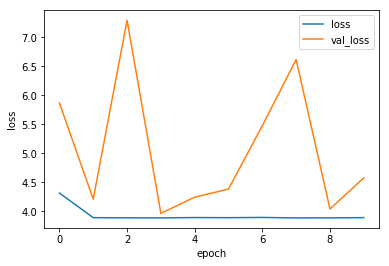

In [17]:
plt.plot(xception_model.history.history['loss'], label='loss')
plt.plot(xception_model.history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [7]:
resnet50_model = get_pretrained_model('xception', 50)

83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
____________________________________________

In [10]:
resnet50_model.fit_generator(train_generator,
                            steps_per_epoch=1164, 
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=312)

Epoch 1/10
1164/1164 [==============================] - 864s 742ms/step - loss: 3.2214 - acc: 0.2716 - val_loss: 15.7179 - val_acc: 0.0242
Epoch 2/10
1164/1164 [==============================] - 769s 661ms/step - loss: 3.1881 - acc: 0.2705 - val_loss: 15.7998 - val_acc: 0.0189
Epoch 3/10
1164/1164 [==============================] - 769s 661ms/step - loss: 3.2329 - acc: 0.2691 - val_loss: 15.8037 - val_acc: 0.0193
Epoch 4/10
1164/1164 [==============================] - 768s 660ms/step - loss: 3.2269 - acc: 0.2712 - val_loss: 15.7422 - val_acc: 0.0223
Epoch 5/10
1164/1164 [==============================] - 769s 661ms/step - loss: 3.2082 - acc: 0.2770 - val_loss: 15.8087 - val_acc: 0.0179
Epoch 6/10
1164/1164 [==============================] - 770s 661ms/step - loss: 3.1854 - acc: 0.2730 - val_loss: 15.7692 - val_acc: 0.0209
Epoch 7/10
1164/1164 [==============================] - 769s 661ms/step - loss: 3.2092 - acc: 0.2769 - val_loss: 15.8231 - val_acc: 0.0179
Epoch 8/10
1164/1164 [=====

In [11]:
resnet50_model.save_weights('resnet50_model_10_1.h5')

In [13]:
resnet50_model.history.history

{'val_loss': [15.717904552435263,
  15.799758840717052,
  15.80365315065338,
  15.742202504680016,
  15.808726679647332,
  15.769213653490976,
  15.823056375616817,
  15.816889547038805,
  15.801386859214134,
  15.852835880236679],
 'val_acc': [0.024238782051282052,
  0.01886035313001605,
  0.019261637239165328,
  0.022271268057784913,
  0.017857142857142856,
  0.02086677367576244,
  0.017857142857142856,
  0.017455858747993578,
  0.019261637239165328,
  0.01585072231139647],
 'loss': [3.2214362696069214,
  3.18806889509827,
  3.23287814220612,
  3.2268750869326577,
  3.2081814491257226,
  3.185409359608319,
  3.2091734550662876,
  3.2013597748533558,
  3.165127386137382,
  3.152664312843195],
 'acc': [0.27158505154639173,
  0.2704574742268041,
  0.2690614261168385,
  0.2712091924398625,
  0.2769544673539519,
  0.27303479381443296,
  0.2769007731958763,
  0.2801224226804124,
  0.28302190721649484,
  0.2849548969072165]}

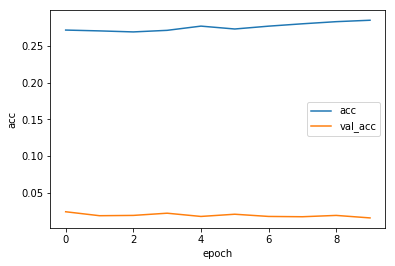

In [14]:
plt.plot(resnet50_model.history.history['acc'], label='acc')
plt.plot(resnet50_model.history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

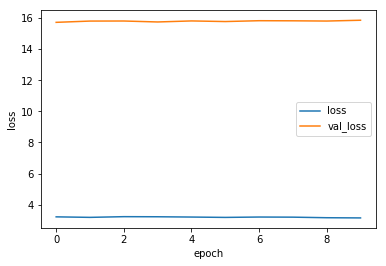

In [15]:
plt.plot(resnet50_model.history.history['loss'], label='loss')
plt.plot(resnet50_model.history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [13]:
resnet50_model.fit_generator(train_generator,
                            steps_per_epoch=1164, 
                            epochs=20,
                            validation_data=validation_generator,
                            validation_steps=312)

Epoch 1/20
1164/1164 [==============================] - 888s 763ms/step - loss: 3.9868 - acc: 0.0775 - val_loss: 13.6759 - val_acc: 0.0224
Epoch 2/20
1164/1164 [==============================] - 821s 706ms/step - loss: 3.4062 - acc: 0.1665 - val_loss: 15.5176 - val_acc: 0.0219
Epoch 3/20
1164/1164 [==============================] - 819s 704ms/step - loss: 3.3359 - acc: 0.1971 - val_loss: 15.7601 - val_acc: 0.0209
Epoch 4/20
1164/1164 [==============================] - 821s 705ms/step - loss: 3.3395 - acc: 0.2100 - val_loss: 15.8106 - val_acc: 0.0154
Epoch 5/20
1164/1164 [==============================] - 813s 699ms/step - loss: 3.2970 - acc: 0.2261 - val_loss: 15.7585 - val_acc: 0.0207
Epoch 6/20
1164/1164 [==============================] - 823s 707ms/step - loss: 3.2901 - acc: 0.2427 - val_loss: 15.8550 - val_acc: 0.0148
Epoch 7/20
1164/1164 [==============================] - 824s 708ms/step - loss: 3.2429 - acc: 0.2567 - val_loss: 15.8257 - val_acc: 0.0171
Epoch 8/20
1164/1164 [=====

In [14]:
resnet50_model.history.history

{'val_loss': [13.675923857933435,
  15.517647606985909,
  15.760064705225668,
  15.810643381330022,
  15.758513871586342,
  15.855008494222528,
  15.825696969682868,
  15.837623179819955,
  15.86230814705691,
  15.8691252468103,
  15.846803306959222,
  15.8357182651232,
  15.881952135750417,
  15.784825914361504,
  15.756222415697517,
  15.844814087759051,
  15.791284450941253,
  15.865117383806894,
  15.846107620680122,
  15.874447132190197],
 'val_acc': [0.022435897435897436,
  0.021869983948635634,
  0.02086677367576244,
  0.01544943820224719,
  0.0206661316211878,
  0.014847512038523275,
  0.017054574638844303,
  0.015248796147672551,
  0.014044943820224719,
  0.014245585874799358,
  0.016653290529695025,
  0.016051364365971106,
  0.01384430176565008,
  0.01946227929373997,
  0.021468699839486356,
  0.016252006420545747,
  0.01906099518459069,
  0.014245585874799358,
  0.01585072231139647,
  0.014245585874799358],
 'loss': [3.9868161844224046,
  3.405915420695374,
  3.3362396628836

In [17]:
resnet50_model.save_weights('resnet50_model_20.h5')

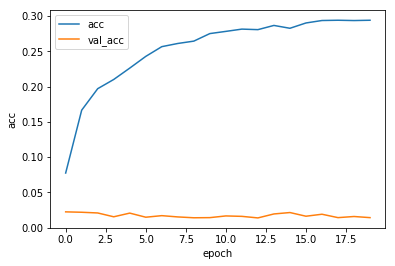

In [15]:
plt.plot(resnet50_model.history.history['acc'], label='acc')
plt.plot(resnet50_model.history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

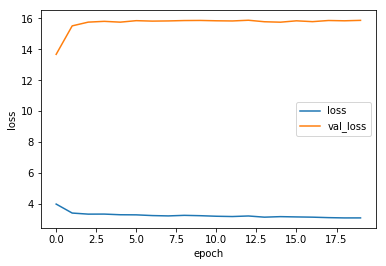

In [16]:
plt.plot(resnet50_model.history.history['loss'], label='loss')
plt.plot(resnet50_model.history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

## Final model selected is VGG16 since VGG16 performed best given both the smaller and larger dataset, used so far.

In [10]:
################################
## Using VGG16 for prediction
################################

In [55]:
test_generator = datagen.flow_from_directory(
    directory="./images/test/",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 2500 images belonging to 1 classes.


In [56]:
test_generator.reset()

In [57]:
len(test_generator)

157

In [60]:
result_vgg16 = vgg16_model.predict_generator(test_generator, steps=157, verbose=1)

157/157 [==============================] - 83s 531ms/step


In [14]:
result_vgg16

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.7087939e-25],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.0386096e-33,
        0.0000000e+00, 1.3457976e-20],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [61]:
len(result_vgg16)

2500

In [62]:
predicted_class_indices=np.argmax(result_vgg16,axis=1)
predicted_class_indices

array([16, 37,  8, ..., 37, 26, 16])

In [63]:
len(predicted_class_indices)

2500

In [64]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [65]:
predictions

['1342',
 '5832',
 '11156',
 '3155',
 '2729',
 '3155',
 '11156',
 '11153',
 '1342',
 '8940',
 '9770',
 '8940',
 '1342',
 '3155',
 '10267',
 '3155',
 '3155',
 '10683',
 '3155',
 '207',
 '11153',
 '5832',
 '3155',
 '3155',
 '3155',
 '10683',
 '9770',
 '1342',
 '11153',
 '1471',
 '1342',
 '4723',
 '8940',
 '1471',
 '3155',
 '1342',
 '11156',
 '11156',
 '3155',
 '3155',
 '11156',
 '9770',
 '1342',
 '3155',
 '8940',
 '11156',
 '11156',
 '3155',
 '10683',
 '8940',
 '3155',
 '9770',
 '1342',
 '5832',
 '1342',
 '10683',
 '8940',
 '5832',
 '3155',
 '5832',
 '10683',
 '1342',
 '9770',
 '3155',
 '3155',
 '3155',
 '9770',
 '9770',
 '11156',
 '11156',
 '10683',
 '1342',
 '8940',
 '3155',
 '10683',
 '5832',
 '11153',
 '11156',
 '1342',
 '11153',
 '9770',
 '8940',
 '10683',
 '9770',
 '3155',
 '4723',
 '10267',
 '1471',
 '3155',
 '10267',
 '1342',
 '11156',
 '3155',
 '5832',
 '10267',
 '11153',
 '3155',
 '3155',
 '9770',
 '5832',
 '9770',
 '1342',
 '1342',
 '5832',
 '3155',
 '3155',
 '5832',
 '2729',


In [35]:
len(test_generator.filenames)

2500

In [66]:
orig_image_ids=[image_file.replace('.jpg','').replace('predict/','') for image_file in test_generator.filenames]
len(orig_image_ids)

2500

In [67]:
labels_actual = []
for id in orig_image_ids:
    l = id.split('_')
    labels_actual.extend(l[2:])
    
len(labels_actual)

2500

In [68]:
from sklearn.metrics import accuracy_score
accuracy_score(labels_actual, predictions)

0.0192

In [69]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_vgg.csv",index=False)

In [1]:
# calculate final evaluation GAP (Global Average Precision)
# GAP=1/M∑ P(i)rel(i)
def calculate_gap(predictions, labels):
    return np.sum(np.cumsum(predictions==labels)*(predictions==labels)/np.arange(1,len(labels)+1)/2500)

In [ ]:
calculate_gap(predictions, labels_actual)

### As stated earlier, the VGG 16 performed best given both the smaller and larger dataset, I used. 
There should be some way to deal with non-landmark images interacting with the classifiers described above. If I can integrate it with my VGG16 model, then I should be able to make my model extremely improved for landmark classification. Also, I would like to run the VGG16 on the entire dataset, for many epochs, so I could have very well-trained weights, that wouldn’t be over fitted to any dataset